In [35]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from geopack import geopack
import sys
import pandas as pd
import seaborn as sns
import xarray as xr
from scipy import stats

#sys.path.append('/Users/sr2/opt/anaconda3/envs/nipr_env/') #MAc
#sys.path.append('/home/ryuho/anaconda3/envs/smrai_env') #Laptop
sys.path.append('/home/sachin/miniconda3/envs/torch_env/') #sever
from esn_dts_openloop import ESN, Tikhonov

In [36]:
#REPPU otuputs
#path = r'/Users/sr2/OneDrive - University College London/PhD/Experiences/Postdocs/JSPS/Research/Data/pbig5min.dat'
#path = r'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Data/pbig5min.dat'
#ath = r'/home/sachin/Documents/NIPR/Research/Data/REPPU/fbig5min.dat' #Server
path = r'/home/sachin/Documents/NIPR/Research/Data/REPPU/fbig5minss.dat' #Server

#read the REPPU data
with open (path) as f:
    rectype = np.dtype(np.float32)
    reppu_data = np.fromfile(f, rectype) #size = 109,900,800

In [37]:
#Read MHD dates and expand-out the date ranges
mhd_data = pd.read_csv('mhd_dates.csv')
expanded_dt = pd.concat([pd.Series(pd.date_range(start, end)) 
        for start, end in zip(mhd_data['start'], mhd_data['end'])])

In [38]:
# Reshape the array to have dimensions (days, time (5-min intervals), lat, lon)
#288 will become 1440 at 1-min resolution in SMRAI v3.0
data_reshaped = reppu_data.reshape(len(expanded_dt), 288, 30, 80) 

# Define coordinates
time = np.arange(288)
lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°

# Create 'dt' variable combining dates and five-minute intervals
dt = []
for day in expanded_dt:
    for t in time:
        dt.append(day + pd.Timedelta(minutes=t*5))
dt = np.array(dt) #convert from list to numpy array

# Create xarray Dataset
ds = xr.Dataset({'current': (['dt', 'lat', 'lon'], data_reshaped.reshape(-1, 30, 80))},
                coords={'dt': dt, 'lat': lat, 'lon': lon})

# Add current and units
ds['current'].attrs['units'] = 'mA/m^2'
ds['current'] = ds['current'] * 1e6 #convert from A to uA
ds

<xarray.Dataset> Size: 440MB
Dimensions:  (dt: 45792, lat: 30, lon: 80)
Coordinates:
  * dt       (dt) datetime64[ns] 366kB 2021-05-10 ... 2022-07-31T23:55:00
  * lat      (lat) float64 240B 53.1 54.36 55.62 56.89 ... 87.18 88.44 89.7
  * lon      (lon) float64 640B 1.6 6.106 10.61 15.12 ... 348.6 353.1 357.6
Data variables:
    current  (dt, lat, lon) float32 440MB 0.01009 0.01013 0.01018 ... 0.0 0.0

In [39]:
meal_val = ds['current'].values.flatten()
variance_val = np.var(meal_val)
skewness_val = stats.skew(meal_val)
kurtosis_val = stats.kurtosis(meal_val)
print(f'Variance: {variance_val}, Skewness: {skewness_val}, Kurtosis: {kurtosis_val}')

Variance: 0.015984823927283287, Skewness: 0.4700276152098533, Kurtosis: 17.444207592639923


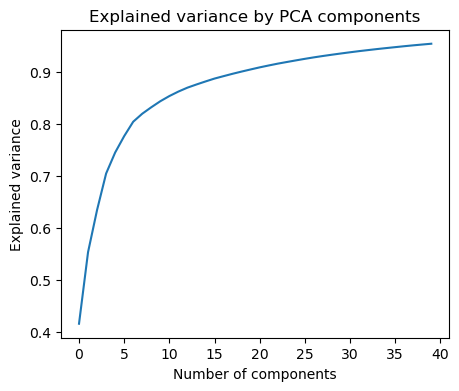

In [40]:
def create_PCA(ds, pca_comps, plot=False):

    ds = ds.copy()

    #reshape the data to be 2D
    ds_arr = ds['current'].values
    ds_arr = ds_arr.reshape(ds_arr.shape[0], -1)

    #create PCA object with the number of components
    pca = PCA(n_components=pca_comps)
    pca.fit(ds_arr)
    pickle.dump(pca, open('/home/sachin/Documents/NIPR/Research/Data/ESN/models/ESN_current_pca_ID8.pkl', 'wb'))
    reduced = pca.transform(ds_arr) #transform the data into the PCA space

    #return data to original space
    #inverse_transform = pca.inverse_transform(reduced)
    #print(inverse_transform.shape)

    if plot == True:
        # Plot the explained variance
        plt.figure(figsize=(5, 4))
        plt.plot(np.cumsum(pca.explained_variance_ratio_))
        plt.xlabel('Number of components')
        plt.ylabel('Explained variance')
        plt.title('Explained variance by PCA components')
        plt.show()

    ds_pca = xr.Dataset({'current': (['dt', 'PC'], reduced)},
                        coords={'dt': ds['dt'], 'PC': np.arange(1, pca_comps+1)})

    return ds_pca, pca

pca_comps = 40
ds, pca = create_PCA(ds, pca_comps, plot=True)

In [41]:
#open the omni data and merge it with the REPPU data
omni_mhd_path = r'/home/ryuho/Documents/reddy/research/SMRAI/Data/OMNI/'

#omni_df = pd.read_csv('omni_mhd_5min.csv')
omni_df = pd.read_csv('omni_add-feats_mhd_5min.csv')
#omni_df = pd.read_csv(omni_mhd_path+'omni_mhd_5min.csv')
omni_df.set_index('dt', inplace=True) #set the datetime as the index
omni_df = omni_df.dropna()

omni_ds = xr.Dataset(omni_df)
omni_ds['dt'] = pd.to_datetime(omni_ds['dt']) #convert the index to datetime

#merge OMNI with REPPU data
reppu_omni_ds = ds.merge(omni_ds, join='inner')
reppu_omni_ds.sortby('dt')

reppu_omni_ds = reppu_omni_ds.drop(['BSN_x','SYM_H','F10.7','Kp','T','Mach_num','E','proton_density'])
#reppu_omni_ds = reppu_omni_ds.drop(['flow_speed','proton_density'])
reppu_omni_ds

/tmp/ipykernel_7288/3506758357.py:17: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  reppu_omni_ds = reppu_omni_ds.drop(['BSN_x','SYM_H','F10.7','Kp','T','Mach_num','E','proton_density'])


<xarray.Dataset> Size: 9MB
Dimensions:     (dt: 42158, PC: 40)
Coordinates:
  * dt          (dt) datetime64[ns] 337kB 2021-05-10 ... 2022-07-31T23:55:00
  * PC          (PC) int64 320B 1 2 3 4 5 6 7 8 9 ... 32 33 34 35 36 37 38 39 40
Data variables:
    current     (dt, PC) float32 7MB 0.7138 -1.109 0.7107 ... 0.1684 -0.1636
    BY_GSE      (dt) float64 337kB 4.72 4.35 4.61 4.65 ... -8.77 -9.31 -8.22
    BZ_GSE      (dt) float64 337kB 6.24 6.55 6.56 6.89 ... -0.74 -4.03 -4.71
    flow_speed  (dt) float64 337kB 344.0 344.0 345.0 344.0 ... 454.0 465.0 478.0
    Pressure    (dt) float64 337kB 2.87 2.72 3.02 3.0 ... 2.79 3.33 3.06 3.13
    doy         (dt) float64 337kB 130.0 130.0 130.0 130.0 ... 212.0 212.0 212.0
    tilt_angle  (dt) float64 337kB 0.253 0.2497 0.2465 ... 0.2778 0.2744 0.271

In [42]:
dates_to_remove = pd.date_range(start='2021-05-10 00:00:00', end='2021-05-10 23:55:00', freq='5min')
date_1_ds = reppu_omni_ds.where(reppu_omni_ds['dt'].isin(dates_to_remove), drop=True)
mask = ~reppu_omni_ds['dt'].isin(dates_to_remove)
date1 = reppu_omni_ds.where(mask, drop=True)

dates_to_remove2 = pd.date_range(start='2021-10-11 00:00:00', end='2021-10-11 23:55:00', freq='5min')
date_2_ds = date1.where(date1['dt'].isin(dates_to_remove2), drop=True)
mask2 = ~date1['dt'].isin(dates_to_remove2)
date2 = date1.where(mask2, drop=True)

dates_to_remove3 = pd.date_range(start='2022-01-30 00:00:00', end='2022-01-30 23:55:00', freq='5min')
date_3_ds = date2.where(date2['dt'].isin(dates_to_remove3), drop=True)
mask3 = ~date2['dt'].isin(dates_to_remove3)
reppu_omni_ds = date2.where(mask3, drop=True)
reppu_omni_ds

<xarray.Dataset> Size: 9MB
Dimensions:     (dt: 41303, PC: 40)
Coordinates:
  * dt          (dt) datetime64[ns] 330kB 2021-05-11 ... 2022-07-31T23:55:00
  * PC          (PC) int64 320B 1 2 3 4 5 6 7 8 9 ... 32 33 34 35 36 37 38 39 40
Data variables:
    current     (dt, PC) float32 7MB 0.593 -1.152 0.7308 ... 0.1684 -0.1636
    BY_GSE      (dt) float64 330kB 4.2 4.22 4.19 3.78 ... -8.77 -9.31 -8.22
    BZ_GSE      (dt) float64 330kB -0.59 -0.7 -0.92 -1.74 ... -0.74 -4.03 -4.71
    flow_speed  (dt) float64 330kB 340.0 343.0 344.0 345.0 ... 454.0 465.0 478.0
    Pressure    (dt) float64 330kB 2.07 1.99 2.03 2.08 ... 2.79 3.33 3.06 3.13
    doy         (dt) float64 330kB 131.0 131.0 131.0 131.0 ... 212.0 212.0 212.0
    tilt_angle  (dt) float64 330kB 0.2575 0.2542 0.2509 ... 0.2778 0.2744 0.271

In [43]:
# Define the slice ranges for train and test data
train_slice = slice(0, 36576)  #36576 / 24 / 12 = 127 days = 80% of the data
test_slice = slice(36576, None)  # 9216 / 24 / 12 = 32 days = 20% of the data

# Create ds_train and ds_test datasets
ds_train = reppu_omni_ds.isel(dt=train_slice)
ds_test = reppu_omni_ds.isel(dt=test_slice)

In [44]:
#training
X_train = ds_train.drop_vars('current').to_array().values.T #drop the current and keep the rest
y_train = ds_train['current'].values

#testing
X_test = ds_test.drop_vars('current').to_array().values.T #drop the current and keep the rest
y_test = ds_test['current'].values
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((36576, 6), (36576, 40), (4727, 6), (4727, 40))

In [45]:
input_dim = X_train.shape[1] #number of input features
output_dim = y_train.shape[1] #number of output features
reservoir_size = 450 #number of reservoir neurons (Nodes in graph)
density = 0.2 #connection density (Edges in the graph)
input_scaling = 0.1 #scaling of input weights
spectral_radius = 0.99 #spectral radius of the recurrent matrix
beta = 1e-2 #regularization factor

In [46]:
model = ESN(input_dim, output_dim, reservoir_size, density, input_scaling, spectral_radius)
optimizer = Tikhonov(input_dim, reservoir_size, output_dim, beta=beta)
model.train(X_train, y_train, optimizer)

array([[ 233.72085793,  223.18880838,  -85.35434358, ..., -595.69523462,
        -616.98989136,  476.62118264],
       [ 234.09477256,  226.65387687,  -84.35299911, ..., -601.27793682,
        -620.3266803 ,  472.78745969],
       [ 234.15872176,  227.39147443,  -85.19456255, ..., -602.29950972,
        -621.96987039,  473.93385481],
       ...,
       [ 264.98188006,  198.26968736,  -87.496857  , ..., -696.70551251,
        -739.50155206,  632.85345129],
       [ 260.45824257,  187.77027697,  -84.34500697, ..., -683.65291077,
        -727.58560981,  628.99318226],
       [ 261.18930968,  189.24043234,  -84.63782082, ..., -685.54389047,
        -728.98374244,  629.5204113 ]])

In [47]:
#save or load model
with open('/home/sachin/Documents/NIPR/Research/Data/ESN/models/SMRAI2_current_ID8.pkl', 'wb') as f:
    pickle.dump(model, f)

#with open('SMRAI2_current_SR.pkl', 'rb') as f:
#   model = pickle.load(f)

In [48]:
#ds_test.to_netcdf('SMRAI2_current_ID15.nc')

In [49]:
#make prediction on the test data
y_pred = model.predict(X_test)

#inverse transform the data / return to the original space
y_pred_orig = pca.inverse_transform(y_pred)
y_pred_orig = y_pred_orig.reshape(-1, 30, 80) #reshape the prediction to lat, lon
y_test_orig = pca.inverse_transform(y_test)
y_test_orig = y_test_orig.reshape(-1, 30, 80) #reshape the prediction to lat, lon

In [50]:
ds_test['current_pred'] = (('dt', 'lat', 'lon'), y_pred_orig)
ds_test['current_pred'].attrs['units'] = 'mA/m^2'
ds_test['current_test'] = (('dt', 'lat', 'lon'), y_test_orig)
ds_test['current_test'].attrs['units'] = 'mA/m^2'

#ds_test = ds_test.drop_vars('current')
#ds_test = ds_test.drop_dims('PC')

ds_test['err_abs'] = np.abs(ds_test['current_pred'] - ds_test['current_test'])
#ds_test['err'] = ds_test['current_pred'] - ds_test['current']
#ds_test['err_pct'] = ds_test['err'] / ds_test['current'] * 100
#ds_test['MLT'] = np.mod(ds_test['lon'] / 15, 24)
ds_test

<xarray.Dataset> Size: 228MB
Dimensions:       (dt: 4727, PC: 40, lat: 30, lon: 80)
Coordinates:
  * dt            (dt) datetime64[ns] 38kB 2022-07-14T21:10:00 ... 2022-07-31...
  * PC            (PC) int64 320B 1 2 3 4 5 6 7 8 9 ... 33 34 35 36 37 38 39 40
Dimensions without coordinates: lat, lon
Data variables:
    current       (dt, PC) float32 756kB 0.9758 3.587 0.5073 ... 0.1684 -0.1636
    BY_GSE        (dt) float64 38kB 6.9 6.66 6.71 6.45 ... -8.77 -9.31 -8.22
    BZ_GSE        (dt) float64 38kB -2.58 -2.45 -2.25 ... -0.74 -4.03 -4.71
    flow_speed    (dt) float64 38kB 383.0 360.0 353.0 ... 454.0 465.0 478.0
    Pressure      (dt) float64 38kB 0.14 0.12 0.1 0.1 ... 2.79 3.33 3.06 3.13
    doy           (dt) float64 38kB 195.0 195.0 195.0 ... 212.0 212.0 212.0
    tilt_angle    (dt) float64 38kB 0.4447 0.4414 0.4381 ... 0.2778 0.2744 0.271
    current_pred  (dt, lat, lon) float64 91MB 0.04713 0.04657 ... 0.0 0.0
    current_test  (dt, lat, lon) float32 45MB 0.02321 0.02183 ... 0.0 0.0
    err_abs       (dt, lat, lon) float64 91MB 0.02392 0.02473 ... 0.0 0.0

In [51]:
current = ds_test['current_test'].values
current = current.reshape(-1, 30, 80)

pred_current = ds_test['current_pred'].values
pred_current = pred_current.reshape(-1, 30, 80)

def skill(m, o):
    skill = 1 - (np.sum((m - o)**2) / np.sum((o - np.mean(o))**2))
    return skill             

RMSE = np.sqrt(np.mean((current - pred_current)**2))
NRMSE = RMSE / (np.max(current) - np.min(current))
MAE = np.mean(np.abs(current - pred_current))
PE = skill(current, pred_current)
R = np.corrcoef(current.flatten(), pred_current.flatten())[0, 1]

print(f'RMSE: {RMSE:.3f} mA/m^2')
print(f'NRMSE: {NRMSE:.3f}')
print(f'MAE: {MAE:.3f} mA/m^2')
print(f'R: {R:.3f}/1')
print(f'PE: {PE:.2f}/1')

RMSE: 0.065 mA/m^2
NRMSE: 0.035
MAE: 0.039 mA/m^2
R: 0.634/1
PE: -0.16/1


In [52]:
#plot hist of AE
sns.histplot(ds_test['err'].values.flatten(), bins=100)
plt.xlabel('Absolute Error (mA/m^2)')
plt.ylabel('Frequency')
plt.yscale('log')

KeyError: "No variable named 'err'. Variables on the dataset include ['current', 'BY_GSE', 'BZ_GSE', 'flow_speed', 'Pressure', ..., 'dt', 'PC', 'current_pred', 'current_test', 'err_abs']"

In [ ]:
# Define common parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .5

# Plot true values
abs_error = np.abs(ds_test['err_abs'].mean('dt').values)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6,5))

c_true = ax.contourf(theta_rad, r, abs_error, levels=np.linspace(0, .2, 40), cmap='rainbow', extend='both')
ax.set_ylim([0, 37])
ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 \nMidday", "15", "18 \nDusk"])
ax.set_title(f'SMRAI 2.1 (ESN) \nAbsolute Error, ID9')
ma = r'$\mathrm{\mu}$/A m$^{-2}$'
plt.colorbar(c_true, ax=ax, label=f'Current (Error) [{ma}]', shrink=shrink, pad=0.1, ticks=np.arange(0,.205,0.05), orientation='horizontal')
ax.grid(True, linestyle='-', alpha=0.6)
plt.tight_layout()
plt.savefig('SMRAI2.1_AE_current_ID9.png', dpi=400)

In [ ]:

#2022-07-12 is worst
#2022-07-31 is okay
#2022-07-25 is best
#2022-07-29 is best
#2022-07-30 is best
date = '2022-07-24'


fig, ax = plt.subplots(figsize=(6, 4))
ds_pred['current'].sel(dt=date).mean(['lat', 'lon']).plot(label='SMRAI2 (Prediction)', color='#648FFF')
ds_test['current'].sel(dt=date).mean(['lat', 'lon']).plot(label='REPPU (G. Truth)', color='#FFB000')

rmse = np.sqrt(np.mean((ds_pred['current'].sel(dt=date).values - ds_test['current'].sel(dt=date).values)**2))
r = np.corrcoef(ds_pred['current'].sel(dt=date).values.flatten(), ds_test['current'].sel(dt=date).values.flatten())[0, 1]

def skill(m, o):
    skill = 1 - (np.sum((m - o)**2) / 
            np.sum((o - np.mean(o))**2))

    return skill  

skill_val = skill(ds_pred['current'].sel(dt=date).values, ds_test['current'].sel(dt=date).values)

ma = r'$\mathrm{\mu}$A/m$^{-2}$'
annotations = [
    (f'RMSE = {rmse:.1f} {ma}', (0.7, 0.05)),
    (f'R = {r:.2f}', (0.7, 0.15)),
    (f'Skill = {skill_val:.2f}', (0.7, 0.25))
]

for annotation, position in annotations:
    annot = plt.annotate(annotation, xy=position, xycoords='axes fraction')
    annot.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))

plt.legend()
par = r'J$_{||}$'
plt.title(f'{date}',pad=8)
plt.xlabel(' ')
plt.ylabel(f'Field Aligned Current ({par}) [{ma}]')
plt.grid(True)
plt.tight_layout()
#plt.savefig('/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/plots/SMRAI3/potential/2022-07-31/rmse.png', dpi=300)

In [ ]:
#loop through all dates in the test and pred dataset and calculate the RMSE then put into a df
rmse_list = []
#r_list = []
#skill_list = []
for date in ds_test['dt']:
    rmse = np.sqrt(np.mean((ds_pred['current'].sel(dt=date).values - ds_test['current'].sel(dt=date).values)**2))
    #r = np.corrcoef(ds_pred['potential'].sel(dt=date).values.flatten(), ds_test['potential'].sel(dt=date).values.flatten())[0, 1]
    #skill_val = skill(ds_pred['potential'].sel(dt=date).values, ds_test['potential'].sel(dt=date).values)
    rmse_list.append(rmse)
    #r_list.append(r)
    #skill_list.append(skill_val)

rmse_df = pd.DataFrame(rmse_list, columns=['RMSE'])
rmse_df['dt'] = ds_test['dt']

rmse_df['date'] = rmse_df['dt'].dt.date
rmse_df['hr'] = rmse_df['dt'].dt.hour
#rmse_df['Kp'] = ds_test['Kp'].values
rmse_df

In [ ]:
rmse_df.groupby('date').mean().sort_values(by='RMSE', ascending=True)

In [ ]:
# Define the date
date = "2022-07-21"

# Extract true and predicted values
current_true = ds_test['current'].sel(dt=date).values[0]
current_pred = ds_pred['current'].sel(dt=date).values[0]

# Calculate the difference
diff = current_true - current_pred

# Set up the plot
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(14, 4.5))

# Define radial and angular coordinates
theta = np.linspace(0, 360, 80) - 90
theta_rad = np.deg2rad(theta)
r = 90 - np.linspace(53.1, 89.7, 30)

#common settings
shrink = .3
levels = np.linspace(-0.50, 0.50+0.01, 100)
c_pad = 0.17
t_pad = 15
ma = r'$\mathrm{\mu}$A/m$^{-2}$'
j_lab = r'J$_{||}$'
current_lab = f'FAC ({j_lab}) [{ma}]'

# Plot true values
c_true = axs[0].contourf(theta_rad, r, current_true, levels=levels, cmap='PRGn', extend='both')
axs[0].set_ylim([0, 30])
axs[0].set_yticks([0, 10, 20, 30])
axs[0].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[0].set_xlim([-np.pi, np.pi])
axs[0].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[0].set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n     Sunrise", "9", "Midday \n12", "15", "18\nSunset     "])
axs[0].set_title(f'True Potential \n (REPPU)', pad=t_pad)
plt.colorbar(c_true, ax=axs[0], label=f'{current_lab}', shrink=shrink, pad=c_pad, 
        ticks=[-0.5, -0.25, 0, 0.25, 0.5], orientation='horizontal')

# Plot predicted values
c_pred = axs[1].contourf(theta_rad, r, current_pred, levels=levels, cmap='PRGn', extend='both')
axs[1].set_ylim([0, 30])
axs[1].set_yticks([0, 10, 20, 30])
axs[1].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[1].set_xlim([-np.pi, np.pi])
axs[1].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[1].set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n     Sunrise", "9", "Midday \n12", "15", "18\nSunset     "])
axs[1].set_title(f'Predicted Potential \n (SMRAI)', pad=t_pad)
plt.colorbar(c_pred, ax=axs[1], label=f'{current_lab}', shrink=shrink, pad=c_pad, 
        ticks=[-0.5, -0.25, 0, 0.25, 0.5],  orientation='horizontal')

# Plot difference
c_diff = axs[2].contourf(theta_rad, r, diff, levels=levels, cmap='bwr', extend='both')
axs[2].set_ylim([0, 30])
axs[2].set_yticks([0, 10, 20, 30])
axs[2].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[2].set_xlim([-np.pi, np.pi])
axs[2].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[2].set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n     Sunrise", "9", "Midday \n12", "15", "18\nSunset     "])
axs[2].set_title('Difference \n(True - Predicted)', pad=t_pad)
plt.colorbar(c_diff, ax=axs[2], label=f'Difference [{ma}]', shrink=shrink, pad=c_pad, 
        ticks=[-0.5, -0.25, 0, 0.25, 0.5], orientation='horizontal')

plt.subplots_adjust(wspace=-0.6)  # Adjust horizontal space between subplots

plt.tight_layout()
#plt.savefig('test_2', bbox_inches='tight', dpi=300)


In [ ]:

# Select the date
date = "2022-07-21"

# Extract times from dt dimension info
times = ds_test.sel(dt=date)['dt'].values

# Define radial and angular coordinates
theta = np.linspace(0, 360, 80) - 90
theta_rad = np.deg2rad(theta)
r = 90 - np.linspace(53.1, 89.7, 30)

#common settings
shrink = .3
levels = np.linspace(-0.50, 0.50+0.01, 100)
c_pad = 0.17
t_pad = 15
ma = r'$\mathrm{\mu}$A/m$^{-2}$'
j_lab = r'J$_{||}$'
current_lab = f'FAC ({j_lab}) [{ma}]'


# Loop through each time step
for i, time in enumerate(times):

    current_true = ds_test['current'].sel(dt=date).values[i]
    current_pred = ds_pred['current'].sel(dt=date).values[i]

    # Calculate the difference
    c_diff = current_true - current_pred

    # Set up the plot
    fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(14, 4.5))

    # Plot true values
    c_true = axs[0].contourf(theta_rad, r, current_true, levels=levels, cmap='PRGn', extend='both')
    axs[0].set_ylim([0, 30])
    axs[0].set_yticks([0, 10, 20, 30])
    axs[0].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    axs[0].set_xlim([-np.pi, np.pi])
    axs[0].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs[0].set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n     Sunrise", "9", "Midday \n12", "15", "18\nSunset     "])
    axs[0].set_title(f'True Potential \n (REPPU)', pad=t_pad)
    plt.colorbar(c_true, ax=axs[0], label=f'{current_lab}', shrink=shrink, pad=c_pad, 
        ticks=[-0.5, -0.25, 0, 0.25, 0.5], orientation='horizontal')

    # Plot predicted values
    c_pred = axs[1].contourf(theta_rad, r, current_pred, levels=levels, cmap='PRGn', extend='both')
    axs[1].set_ylim([0, 30])
    axs[1].set_yticks([0, 10, 20, 30])
    axs[1].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    axs[1].set_xlim([-np.pi, np.pi])
    axs[1].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs[1].set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n     Sunrise", "9", "Midday \n12", "15", "18\nSunset     "])
    axs[1].set_title(f'Predicted Potential \n (SMRAI)', pad=t_pad)
    plt.colorbar(c_pred, ax=axs[1], label=f'{current_lab}', shrink=shrink, pad=c_pad, 
        ticks=[-0.5, -0.25, 0, 0.25, 0.5],  orientation='horizontal')

    c_diff = axs[2].contourf(theta_rad, r, diff, levels=levels, cmap='bwr', extend='both')
    axs[2].set_ylim([0, 30])
    axs[2].set_yticks([0, 10, 20, 30])
    axs[2].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    axs[2].set_xlim([-np.pi, np.pi])
    axs[2].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs[2].set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n     Sunrise", "9", "Midday \n12", "15", "18\nSunset     "])
    axs[2].set_title('Difference \n(True - Predicted)', pad=t_pad)
    plt.colorbar(c_diff, ax=axs[2], label=f'Difference [{ma}]', shrink=shrink, pad=c_pad, 
        ticks=[-0.5, -0.25, 0, 0.25, 0.5], orientation='horizontal')

    plt.subplots_adjust(wspace=-0.7)  # Adjust horizontal space between subplots

    plt.tight_layout()

    #add the time to the plot
    dt = pd.to_datetime(time)
    str_time = dt.strftime('%Y-%m-%d %H-%M')
    plt.annotate(f'{str_time}', xy=(-1.45, -0.7), xycoords='axes fraction', fontsize=12)

    # Save the figure with the timestamp in the title
    plt.savefig(f'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/plots/SMRAI3/current/2022-07-21/current_plot_{str_time}.png', dpi=300, bbox_inches='tight')
    
    # Close the figure to free up memory
    plt.close(fig)

    #break after n interations
    if i in [10]:
        break

